# Replication of Gennaro & Ash "Emotion and reason in political language"

| Author | Last update |
|:------ |:----------- |
| Hauke Licht (https://github.com/haukelicht) | 2023-09-26 |

In their [publication](https://academic.oup.com/ej/article/132/643/1037/6490125) "Emotion and reason in political language," Gennaro and Ash combine dictionaries and word embeddings to quantify how the emotionality of speeches in the U.S. congress has evolved over time.

## Replication: goals and approach

In this notebook, we replicate their analyses.
Out goal is to see if we find intersting patterns with their method when we apply it to another text corpus.

## Author's note

I have oriented my implementation as close as possible at Gennaro & Ash's [replication materials](https://zenodo.org/record/5748084).
Discrepancies of my findings from theirs thus have to do with using a different embedding model and a different target corpus.


## Measurement strategy

#### Indicating "reason" and "cognition" with keywords

To build lists of emotive and cognitive words, they  started with the  *Linguistic Inquiry and Word Count* (LIWC) dicationary.
Specifically, they took 

- words in the "Cognitive Processing" category (799 words, phrases and wildcard expressions) to indicate their "reasoning" concept, and 
- words in the "Affective Processing" category (1,445 tokens, phrases and wildcard expressions) to indicate their "emotion" concept.

They than manually reviewed terms one at a time to discard "inappropriate" terms like multi-word expressions or emojis.
This left them with two lists of stemmed nouns, verbs and adjectives:

- _A_: affective processing terms (629 tokens)
- _C_: cognitive processing terms (169 tokens)

#### Word embedding model

They train a Word2Vec model on their full corpus of U.S. Congress speeches.

**_Note:_** We don't have access to their corpus, so we'll just use a pre-trained model.

#### Scaling speeches

They take their embeddings and keyword lists to scale speeches in the Congressional Record with an **emotionality score.**

1. the word embeddings are combined with the thematic word lists to isolate directions in embedding space corresponding to emotion and reason.
    - The vector $\mathbf{a}$ representing "emotion" is the average of the vectors $\mathbf{v}_w$ for the words in the emotion word list, $w \in A$. 
    - The vector $\mathbf{c}$ representing "cognition" is the average of the vectors $\mathbf{v}_w$ for the words in the cognitoon word list, $w \in C$. 
2. they produce a vector representation $mathbf{d}_i$ for a congressional speech $i$ (i.e., "document") by averaging the embeddings of words $w$ in the speech.
3. they scale each speech with the 

$$
Y_i = \frac{\text{sim}(\mathbf{d}_i, \mathbf{a})+b}{\text{sim}(\mathbf{d}_i, \mathbf{c})+b}
$$

where $\text{sim}(\mathbf{u}, \mathbf{v})$ is the cosine similarity between vectors $\mathbf{u}$ and $\mathbf{v}$.

## Setup

In [52]:
# for data import
import os
import pickle

# for word embeding model
import gensim

# for data frames
import pandas as pd

# for text prepriocessing
import re
from nltk.stem import PorterStemmer
import swifter # <== for parallelization with pandas

# misc
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter

Define paths:

In [6]:
data_dir = os.path.join('..', 'data')
dicts_dir = os.path.join(data_dir, 'replications', 'gennaro_emotion_2022')

### 1. Load the dictionaries of affect and cognition keywords

In [7]:
with open(os.path.join(dicts_dir, 'dictionary_affect.pkl'), 'rb') as f:
    affect_dictionary = pickle.load(f)

with open(os.path.join(dicts_dir, 'dictionary_cognition.pkl'), 'rb') as f:
    cognition_dictionary = pickle.load(f)

### 2. Load and clean an English-language corpus

We don't have access to their U.S. Congress speeches corpus.

So instead, we'll use a corpus of *New York Times* headlines from the years 1990-2022 I have compiled.

**_Note:_** You could also take another English-language corpus.

In [19]:
fp = os.path.join(data_dir, 'corpora', 'nyt_articles', 'nyt_article_headlines_1990-2022.tsv') 
corpus = pd.read_csv(fp, sep='\t')

/var/folders/_c/cm0nk6y92rz2l6ct3npgw9tr0000gn/T/ipykernel_86707/3446995734.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  corpus = pd.read_csv(fp, sep='\t')


This corpus has text in its 'headline', 'abstract', and 'lead_paragraph' columns.
Moreover, each article is described with rich metadata that allows interesting comparative analysis.

In [20]:
corpus.head(2)

,year,month,web_url,headline,abstract,lead_paragraph,keywords,pub_date,document_type,section_name,type_of_material
1,1990,1,https://www.nytimes.com/1990/01/01/nyregion/br...,Bridge,LEAD: One of the many sad bridge stories of 19...,One of the many sad bridge stories of 1989 con...,subject:Bridge (Card Game),1990-01-01 05:00:00,article,New York,News
2,1990,1,https://www.nytimes.com/1990/01/01/sports/spor...,He Has Tyson On His Mind,LEAD: THOSE on Donovan Ruddock's Christmas-car...,THOSE on Donovan Ruddock's Christmas-card list...,"persons:RUDDOCK, DONOVAN;persons:Tyson, Mike;s...",1990-01-01 05:00:00,article,Sports,News


#### Subsetting

Let's inspect the distribution of article metadata and subset if necessary:

In [21]:
corpus.document_type.value_counts()

document_type
article          319087
Magazine              6
New York              3
Business Day          2
Sports                1
World                 1
Archives              1
Home & Garden         1
Education             1
Name: count, dtype: int64

In [22]:
# subset to articles
corpus = corpus[corpus.document_type == 'article']

In [23]:
corpus.section_name.value_counts()

section_name
Business Day      81711
New York          50943
Sports            33214
World             22322
U.S.              21847
Opinion           20745
Style             18490
Arts              16463
Books              9555
Obituaries         8411
Home & Garden      5376
Magazine           4672
Travel             4589
Real Estate        4574
Archives           3632
Week in Review     3460
Movies             3451
Theater            2349
Science            2186
Education           600
Health              284
T Magazine           76
Automobiles          74
Technology           43
Corrections          10
Job Market            6
Food                  4
Name: count, dtype: int64

In [24]:
# add a manual categorization
manual_categorion = {
    'politics': [
        'World',
        'U.S.',
    ],
    'life style': [
        'Style',
        'Home & Garden',
        'Real Estate',
        'Travel',
        'Health',
    ],
    'culture': [
        'Sports',
        'Arts',
        'Books',
        'Movies',
        'Theater'
    ],
    'hard news': [
        'Science',
        'Education',
        'Technology',
        'Business Day',
    ],
    'misc': [
        'New York',
        'Opinion',
        'Magazine',
        'Archives',
        'Obituaries',
        'Week in Review',
        'T Magazine',
        'Automobiles',
        'Corrections',
        'Job Market',
        'Food'
    ]
}
manual_categories_lookup = {v: k for k, vs in manual_categorion.items() for v in vs}
corpus['category'] = corpus.section_name.apply(lambda x: manual_categories_lookup[x])

In [25]:
corpus.type_of_material.value_counts()[:10]

type_of_material
News          195509
Statistics     34923
Review         20844
Letter         19762
Correction      6397
Summary         6361
Biography       6157
Obituary        5271
Editorial       5194
Op-Ed           4995
Name: count, dtype: int64

Let's take 'News' materials and combine the values in the text columns for each article: 

In [26]:
# subset
news_corpus = corpus[corpus.type_of_material == 'News']

#### Preprocessing

In [28]:
# concat texts
news_corpus['text'] = \
    news_corpus['headline'] + ' ' + \
    news_corpus['abstract'].str.replace('LEAD: ', ' ') + ' ' + \
    news_corpus['lead_paragraph']

# drop NAs
news_corpus = news_corpus[~news_corpus.text.isna()]

In [33]:
# stem words in the corpus
ps = PorterStemmer()

def preprocess(text):
    # replace extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    words = [ps.stem(w) for w in text.split(' ')]
    return ' '.join(words)

news_corpus['text_preprocessed'] = news_corpus.text.swifter.apply(preprocess)

Pandas Apply:   0%|          | 0/195499 [00:00<?, ?it/s]

As a next step, we want to compute words frequencies in the target corpus.
We will need this information to re-weigh keywords.

**_Note:_** This is not reported in the paper but in their replication code.

In [34]:
# compute word frequencies (to re-weigh dictionary words)
word_freqs = Counter()

for sent in tqdm(news_corpus.text):
    word_freqs.update(sent.lower().split(' '))

word_freqs = dict(word_freqs)

  0%|          | 0/195499 [00:00<?, ?it/s]

### 3. Load the embedding model

In [35]:
import gensim.downloader as api

# load a pre-trained word2vec model
model = api.load('word2vec-google-news-300')

**_Note:_** If you use the UK parliamentary speeches corpus, you can also load the corresponding word2vec model I have trained:

In [21]:
# Note: if you use the 
# # load model
# from gensim.models import KeyedVectors
# fp = '../data/models/uk_commons/word2vec_uk-parl-d300_w10.kv'
# wv = KeyedVectors.load_word2vec_format(fp, binary=True)

### 4. implement the computation steps

We first need a function to compute a weighted average of indicator words embeddings into concept centroids:

In [37]:
# compute centroids
import numpy as np
def find_centroid(words, word_freqs, model):
    words = [w for w in words if w in model.index_to_key and w in word_freqs]
    vecs = [model[w] * word_freqs[w] for w in words]
    vecs = [v for v in vecs if len(v) > 0]
    centroid = np.mean(vecs, axis=0)
    # centroid = centroid.reshape(1, -1)
    return centroid

Now we can compute the centroids

In [38]:
c_affect = find_centroid(words=affect_dictionary, word_freqs=word_freqs, model=model)
c_cognition = find_centroid(words=cognition_dictionary, word_freqs=word_freqs, model=model)

The next function is most **important.** 
It implements their metric:

$$
Y_i = \frac{\text{sim}(\mathbf{d}_i, \mathbf{a})+b}{\text{sim}(\mathbf{d}_i, \mathbf{c})+b}
$$


In [43]:
from scipy.spatial.distance import cosine

def compute_doc_score(text, word_freqs, word_vectors):
    # tokenized preprocessed text
    words = text.split(' ')
    # compute document representation (re-weighing by word frequencies)
    vecs = [word_vectors[w] * word_freqs[w] for w in words if w in word_vectors and w in word_freqs]
    if len(vecs) == 0:
        return [np.nan]*3
    
    v = np.mean(vecs, axis=0)  # take mean

    a = 1-cosine(v, c_affect) # <== hard coded
    c = 1-cosine(v, c_cognition) # <== hard coded
    
    score = (a + 1) / (c + 1)
    
    return [a, c, score] # [similarity to affect, similarity to cognition, overall score]


In [44]:
# test
test = news_corpus.text_preprocessed.values[0].lower()
print(test)
a, c, s =  compute_doc_score(test, word_freqs, model)
print(f'affect: {a:.2f}, cognition: {c:.2f}, score: {s:.2f}')

bridg one of the mani sad bridg stori of 1989 concern the final of the australian nation team championship, play in canberra, the capital, in february. it attract an entri of 178 teams, far more than an equival american event would do, and there were player from new zealand, japan and the unit one of the mani sad bridg stori of 1989 concern the final of the australian nation team championship, play in canberra, the capital, in february. it attract an entri of 178 teams, far more than an equival american event would do, and there were player from new zealand, japan and the unit states.
affect: 0.37, cognition: 0.43, score: 0.96


The next function is just a helper function to perform computations on all documents in a data frame:

In [48]:
def compute_docs_scores(df: pd.DataFrame, text_col: str, id_col: str, tolower: bool = True):
    out = []
    df = df[~df[text_col].isna()]
    df = df[df[text_col].apply(len) > 0]
    if tolower:
        df[text_col] = df[text_col].str.lower()
    # note: we could parallelize this for loop
    for i, text in tqdm(zip(df[id_col], df[text_col]), total=len(df)):
        s = compute_doc_score(text, word_freqs, model) # <= hard coded
        out.append([i] + s)
    return out

# test
compute_docs_scores(news_corpus.head(5), text_col='text_preprocessed', id_col='web_url')

  0%|          | 0/5 [00:00<?, ?it/s]

[['https://www.nytimes.com/1990/01/01/nyregion/bridge-173390.html',
  0.37388940939168214,
  0.4279316870734251,
  0.9621534572199992],
 ['https://www.nytimes.com/1990/01/01/sports/sports-world-specials-boxing-he-has-tyson-on-his-mind.html',
  0.28067074091957755,
  0.263187088824946,
  1.0138409046841157],
 ['https://www.nytimes.com/1990/01/01/nyregion/for-dinkins-pomp-ceremony-triumph-and-a-dream-realized.html',
  0.3850042680355098,
  0.4425976437259218,
  0.9600766187710797],
 ['https://www.nytimes.com/1990/01/01/business/calm-sought-in-argentina.html',
  0.37085675006425944,
  0.41886711484794703,
  0.9661628884895027],
 ['https://www.nytimes.com/1990/01/01/world/upheaval-in-the-east-noriega-aide-israeli-or-driver-how-signals-cross.html',
  0.4282787567191755,
  0.47561965142786133,
  0.9679179559157556]]

In [49]:
# apply scoring function to each speech
scores = compute_docs_scores(df=news_corpus.sample(10_000), text_col='text_preprocessed', id_col='web_url')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [53]:
# convert to data frame
scores_df = pd.DataFrame(scores, columns=['web_url', 'affect', 'cognition', 'score'])

# add with remaining meta data
scores_joined_df = scores_df.join(news_corpus.set_index('web_url'), on='web_url')

In [54]:
scores_joined_df.groupby('category').score.mean()

category
culture       0.965659
hard news     0.967249
life style    0.967155
misc          0.967568
politics      0.965964
Name: score, dtype: float64

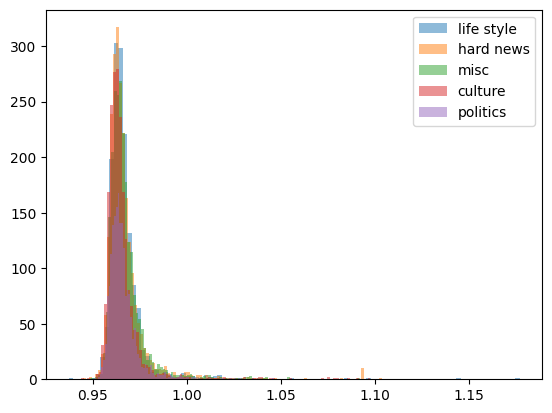

In [55]:
# plot an overlayed histogram of scores by category
for cat in scores_joined_df.category.unique():
    plt.hist(scores_joined_df[scores_joined_df.category == cat].score, bins=100, alpha=0.5, label=cat)
plt.legend()
plt.show()

**Interpretation:**

There seem to be no differences between news categories in how emotional they are!

What could be reasons for our null findings?